# Brasileirão - 2006 a 2024
>Análises estatísticas dos campeonatos brasileiros na era dos pontos corridos, com 20 times e 38 rodadas.

# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import root_mean_squared_error as rmse

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

# Dataprep


## 2006 - 2023

In [2]:
#fonte de dados ref a 2006: https://www.futexcel.com.br/brasileirao/2006.html
#fonte de dados entre 2007 e 2023 (até rodada 25): https://basedosdados.org/dataset/c861330e-bca2-474d-9073-bc70744a1b23?table=18835b0d-233e-4857-b454-1fa34a81b4fa
#fonte de dados 2023 (rodada 27 a 38): https://footystats.org/pt/brazil/serie-a/fixtures

df_2006_2024_ate_rodada_25 = pd.read_csv('../dados/brasileirao_2006_2024_ate_rodada_25.csv', sep = ';', encoding='latin')
df_2006_2024_ate_rodada_25 = df_2006_2024_ate_rodada_25.loc[df_2006_2024_ate_rodada_25.ano_campeonato >=2006]

#selecao de features
list_cols = ['ano_campeonato','rodada','time_mandante','time_visitante','gols_mandante','gols_visitante']
df_2006_2024_ate_rodada_25 = df_2006_2024_ate_rodada_25[list_cols]
df_2006_2024_ate_rodada_25.sort_values(['ano_campeonato','rodada','time_mandante'], inplace = True)
df_2006_2024_ate_rodada_25

,ano_campeonato,rodada,time_mandante,time_visitante,gols_mandante,gols_visitante
318,2006,1,Atlético-PR,Fluminense,1.0,2.0
103,2006,1,Botafogo,Fortaleza,1.0,0.0
106,2006,1,Goiás EC,Santos FC,0.0,0.0
101,2006,1,Grêmio,Corinthians,2.0,0.0
99,2006,1,Juventude,Paraná,1.0,0.0
...,...,...,...,...,...,...
7040,2024,25,EC Vitória,Vasco da Gama,0.0,1.0
6933,2024,25,Fluminense,São Paulo,2.0,0.0
7039,2024,25,Grêmio,Atlético-MG,2.0,3.0
7027,2024,25,Juventude,Internacional,1.0,3.0


## Ajuste na base 2006-2023

In [3]:
# jogos de 2024 após a rodada 25 serão alimentados manualmente através do excel brasileirao2024_rodada26_38.xlsx, pois o site não disponibiliza os jogos mais recentes com a conta gratuita
# além disso, alguns jogos de 2024 estão faltando, principalmente devido ao adiamento dos jogos dos times do SUL devido as fortes chuvas do inicio do ano. 
# Tais jogos, mesmo que pertencentes a rodadas anteriores a 25, serão inseridos na mesma planilha excel.
#São eles:
#rodada 5: Gremio e Criciuma realizado em 25/09
#rodada 6: Atletico MG e Gremio prealizado em 09/10
#rodadas 10 e 11 não apareceram na base 2003-2024, e assim seão inseridos na base excel brasileirao2024_rodada26_38.xlsx
#rodada 16: Bragantino e Internacional realizado em 25/09
#rodada 17: Fluminense e Atletico PR realizado em 22/10
#rodada 17: --> falta placar de Internacional e Flamengo, que está agendado para 30/10

#rodada 19: Cuiabá-MT e Fluminense está de forma equivocada na base 2023 e será dropado
df_2006_2024_ate_rodada_25 = df_2006_2024_ate_rodada_25.loc[~((df_2006_2024_ate_rodada_25.rodada == 19) & (df_2006_2024_ate_rodada_25.time_mandante == 'Cuiabá-MT') & (df_2006_2024_ate_rodada_25.time_visitante == 'Fluminense'))]
#rodada 19: Atlético-PR e Atlético-MG ainda não foi realizado até o momento do download da base df_2006_2024_ate_rodada_25, e assim será informado posteriormente via df_2024_apos_rodada_26
df_2006_2024_ate_rodada_25 = df_2006_2024_ate_rodada_25.loc[~((df_2006_2024_ate_rodada_25.rodada == 19) & (df_2006_2024_ate_rodada_25.time_mandante == 'Athletico-PR') & (df_2006_2024_ate_rodada_25.time_visitante == 'Atlético-MG'))]

df_2006_2024_ate_rodada_25.loc[(df_2006_2024_ate_rodada_25.ano_campeonato == 2024) & (df_2006_2024_ate_rodada_25.rodada == 19)]
#rodada 19: Corinthians e Gremio realizado em 25/07
#rodada 19: Criciuma e Bragantino realizado em 28/08
#rodada 19: Internacional e Fortaleza realizado em 11/09
#rodada 19: Vasco e Cuiaba realizado em 24/10

,ano_campeonato,rodada,time_mandante,time_visitante,gols_mandante,gols_visitante
6945,2024,19,Atlético-GO,EC Bahia,1.0,1.0
6892,2024,19,Cruzeiro,Juventude,2.0,0.0
6894,2024,19,EC Vitória,Flamengo,1.0,2.0
6895,2024,19,Fluminense,Palmeiras,1.0,0.0
6893,2024,19,São Paulo,Botafogo,2.0,2.0


# 2024 | a partir da rodada 26

In [4]:
df_2024_apos_rodada_26 = pd.read_excel('../dados/brasileirao2024_rodada26_38.xlsx')
df_2024_apos_rodada_26.sort_values(['ano_campeonato','rodada','time_mandante'], inplace = True)
df_2024_apos_rodada_26

c:\ProgramData\Anaconda3\envs\brasileiraoenv\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


,ano_campeonato,rodada,time_mandante,time_visitante,gols_mandante,gols_visitante
0,2024,5,Grêmio,Criciúma EC,1.0,2.0
1,2024,6,Atlético-MG,Grêmio,2.0,1.0
3,2024,10,Atlético-GO,Criciúma EC,1.0,2.0
2,2024,10,Botafogo,Atlético-PR,1.0,1.0
8,2024,10,Cruzeiro,Fluminense,2.0,0.0
9,2024,10,EC Vitória,Atlético-MG,4.0,2.0
10,2024,10,Flamengo,EC Bahia,2.0,1.0
5,2024,10,Fortaleza,Grêmio,1.0,0.0
7,2024,10,Internacional,Corinthians,1.0,0.0
6,2024,10,Juventude,Vasco da Gama,2.0,0.0


# Concatenando os df's

In [5]:
df = pd.concat([df_2006_2024_ate_rodada_25, df_2024_apos_rodada_26])
df.sort_values(['ano_campeonato','rodada','time_mandante'], inplace = True)
df['time_mandante'] = df['time_mandante'].apply(lambda x: x.strip())
df['time_visitante'] = df['time_visitante'].apply(lambda x: x.strip())
print(f'Antes do drop_duplicates: {df.shape}')
df.drop_duplicates(subset = ['ano_campeonato', 'rodada', 'time_mandante', 'time_visitante'], keep = 'last', inplace=True)
print(f'Após o drop_duplicates: {df.shape}')
df

Antes do drop_duplicates: (7220, 6)
Após o drop_duplicates: (7220, 6)


,ano_campeonato,rodada,time_mandante,time_visitante,gols_mandante,gols_visitante
318,2006,1,Atlético-PR,Fluminense,1.0,2.0
103,2006,1,Botafogo,Fortaleza,1.0,0.0
106,2006,1,Goiás EC,Santos FC,0.0,0.0
101,2006,1,Grêmio,Corinthians,2.0,0.0
99,2006,1,Juventude,Paraná,1.0,0.0
...,...,...,...,...,...,...
157,2024,38,Fortaleza,Internacional,NaN,NaN
150,2024,38,Grêmio,Corinthians,NaN,NaN
159,2024,38,Juventude,Cruzeiro,NaN,NaN
155,2024,38,Palmeiras,Fluminense,NaN,NaN


# Unificando nomes de times similares

In [6]:
lista_times = df.time_mandante.unique().tolist()
for time in  df.time_visitante.unique():
  if time not in lista_times:
    lista_times.append(time)

display(lista_times.sort())

#duplicidades encontradas
dict_times = {'Athletico-PR' : 'Atlético-PR',
              'Goiás EC' : 'Goiás',
              'Santos FC' : 'Santos'}

df['time_mandante'].replace(dict_times, inplace = True)
df['time_visitante'].replace(dict_times, inplace = True)

display(np.sort(df['time_mandante'].unique()))
display(np.sort(df['time_visitante'].unique()))

None

array(['América-MG', 'América-RN', 'Atlético-GO', 'Atlético-MG',
       'Atlético-PR', 'Avaí FC', 'Barueri', 'Botafogo', 'CSA', 'Ceará SC',
       'Chapecoense', 'Corinthians', 'Coritiba FC', 'Criciúma EC',
       'Cruzeiro', 'Cuiabá-MT', 'EC Bahia', 'EC Vitória',
       'Figueirense FC', 'Flamengo', 'Fluminense', 'Fortaleza', 'Goiás',
       'Grêmio', 'Guarani', 'Internacional', 'Ipatinga FC',
       'Joinville-SC', 'Juventude', 'Náutico', 'Palmeiras', 'Paraná',
       'Ponte Preta', 'Portuguesa', 'RB Bragantino', 'Santa Cruz',
       'Santo André', 'Santos', 'Sport Recife', 'São Caetano',
       'São Paulo', 'Vasco da Gama'], dtype=object)

array(['América-MG', 'América-RN', 'Atlético-GO', 'Atlético-MG',
       'Atlético-PR', 'Avaí FC', 'Barueri', 'Botafogo', 'CSA', 'Ceará SC',
       'Chapecoense', 'Corinthians', 'Coritiba FC', 'Criciúma EC',
       'Cruzeiro', 'Cuiabá-MT', 'EC Bahia', 'EC Vitória',
       'Figueirense FC', 'Flamengo', 'Fluminense', 'Fortaleza', 'Goiás',
       'Grêmio', 'Guarani', 'Internacional', 'Ipatinga FC',
       'Joinville-SC', 'Juventude', 'Náutico', 'Palmeiras', 'Paraná',
       'Ponte Preta', 'Portuguesa', 'RB Bragantino', 'Santa Cruz',
       'Santo André', 'Santos', 'Sport Recife', 'São Caetano',
       'São Paulo', 'Vasco da Gama'], dtype=object)

# Estatística básica

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ano_campeonato,7220.0,2015.000000,5.477605,2006.0,2010.0,2015.0,2020.0,2024.0
rodada,7220.0,19.500000,10.966616,1.0,10.0,19.5,29.0,38.0
gols_mandante,7178.0,1.485511,1.192202,0.0,1.0,1.0,2.0,7.0
gols_visitante,7178.0,0.997492,1.004515,0.0,0.0,1.0,2.0,7.0


# Testes de consistência dos dados - Parte 1

In [8]:
#rodadas por temporada: esperadas 38 (#ok)
display(df.groupby('ano_campeonato')['rodada'].max())

#jogos por campeonato: esperados 380 (#ok)
display(df.groupby(['ano_campeonato'])['time_mandante'].count())



ano_campeonato
2006    38
2007    38
2008    38
2009    38
2010    38
2011    38
2012    38
2013    38
2014    38
2015    38
2016    38
2017    38
2018    38
2019    38
2020    38
2021    38
2022    38
2023    38
2024    38
Name: rodada, dtype: int64

ano_campeonato
2006    380
2007    380
2008    380
2009    380
2010    380
2011    380
2012    380
2013    380
2014    380
2015    380
2016    380
2017    380
2018    380
2019    380
2020    380
2021    380
2022    380
2023    380
2024    380
Name: time_mandante, dtype: int64

In [9]:
#jogos como mandante por time por temporada: esperados 19 jogos
df_jogos_por_time_mandante = df.groupby(['ano_campeonato','time_mandante']).count()#.reset_index()
display('Jogos por time como mandantes, diferente de 19 jogos:',df_jogos_por_time_mandante.loc[df_jogos_por_time_mandante.rodada!=19])#.sort_values('time_mandante'))

#jogos como visitante por time por temporada: esperados 19 jogos
df_jogos_por_time_visitante = df.groupby(['ano_campeonato','time_visitante']).count()#.reset_index()
display('Jogos por time como visitante, diferente de 19 jogos:',df_jogos_por_time_visitante.loc[df_jogos_por_time_visitante.rodada!=19])#.sort_values('time_visitante'))

# Todos os times apresentaram 19 jogos como mandantes e 19 como visitantes por ano, totalizando 38 jogos por campeonato

'Jogos por time como mandantes, diferente de 19 jogos:'

,,rodada,time_visitante,gols_mandante,gols_visitante
ano_campeonato,time_mandante,,,,


'Jogos por time como visitante, diferente de 19 jogos:'

,,rodada,time_mandante,gols_mandante,gols_visitante
ano_campeonato,time_visitante,,,,


# Engenharia de features

In [10]:
df['pontos_mandante'] = df.gols_mandante - df.gols_visitante
df['pontos_mandante'] = df['pontos_mandante'].map(lambda x: 3 if x > 0 else 1 if x == 0 else 0)

df['pontos_visitante'] = df.gols_visitante - df.gols_mandante
df['pontos_visitante'] = df['pontos_visitante'].map(lambda x: 3 if x > 0 else 1 if x == 0 else 0)

df

,ano_campeonato,rodada,time_mandante,time_visitante,gols_mandante,gols_visitante,pontos_mandante,pontos_visitante
318,2006,1,Atlético-PR,Fluminense,1.0,2.0,0,3
103,2006,1,Botafogo,Fortaleza,1.0,0.0,3,0
106,2006,1,Goiás,Santos,0.0,0.0,1,1
101,2006,1,Grêmio,Corinthians,2.0,0.0,3,0
99,2006,1,Juventude,Paraná,1.0,0.0,3,0
...,...,...,...,...,...,...,...,...
157,2024,38,Fortaleza,Internacional,NaN,NaN,0,0
150,2024,38,Grêmio,Corinthians,NaN,NaN,0,0
159,2024,38,Juventude,Cruzeiro,NaN,NaN,0,0
155,2024,38,Palmeiras,Fluminense,NaN,NaN,0,0


In [11]:
#criação de df_mandante e df_visitante para depois concatená-los

#df_mandante
df_mandante = df[['ano_campeonato',	'rodada',	'time_mandante','time_visitante','gols_mandante','gols_visitante']].copy()
df_mandante.rename(columns = {'time_mandante':'time',
                              'time_visitante':'adversário',
                              'gols_mandante':'gols_pro',
                              'gols_visitante': 'gols_contra'}, inplace = True)
df_mandante['pontos'] = df_mandante.gols_pro - df_mandante.gols_contra
df_mandante['pontos'] = df_mandante['pontos'].map(lambda x: 3 if x > 0 else 1 if x == 0 else 0)

#df_visitante
df_visitante = df[['ano_campeonato',	'rodada',	'time_visitante','time_mandante','gols_mandante','gols_visitante']].copy()
df_visitante.rename(columns = {'time_visitante':'time',
                               'time_mandante': 'adversário',
                              'gols_visitante':'gols_pro',
                              'gols_mandante': 'gols_contra'
                              }, inplace = True)

df_visitante['pontos'] = df_visitante.gols_pro - df_visitante.gols_contra
df_visitante['pontos'] = df_visitante['pontos'].map(lambda x: 3 if x > 0 else 1 if x == 0 else 0)

df_concat = pd.concat([df_mandante, df_visitante]).reset_index(drop = True)

#criação das features vitoria, empate, derrota
df_concat['vitoria'] = df_concat['pontos'].map(lambda x: 1 if x == 3 else 0)
df_concat['derrota'] = df_concat['pontos'].map(lambda x: 1 if x == 0 else 0)
df_concat['empate'] = df_concat['pontos'].map(lambda x: 1 if x == 1 else 0)

#anulando dados de rodadas que ainda não aconteceram
df_concat.loc[df_concat.gols_pro != df_concat.gols_pro, ['pontos', 'vitoria', 'derrota', 'empate']] = np.nan

df_concat

,ano_campeonato,rodada,time,adversário,gols_pro,gols_contra,pontos,vitoria,derrota,empate
0,2006,1,Atlético-PR,Fluminense,1.0,2.0,0.0,0.0,1.0,0.0
1,2006,1,Botafogo,Fortaleza,1.0,0.0,3.0,1.0,0.0,0.0
2,2006,1,Goiás,Santos,0.0,0.0,1.0,0.0,0.0,1.0
3,2006,1,Grêmio,Corinthians,2.0,0.0,3.0,1.0,0.0,0.0
4,2006,1,Juventude,Paraná,1.0,0.0,3.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
14435,2024,38,Internacional,Fortaleza,NaN,NaN,NaN,NaN,NaN,NaN
14436,2024,38,Corinthians,Grêmio,NaN,NaN,NaN,NaN,NaN,NaN
14437,2024,38,Cruzeiro,Juventude,NaN,NaN,NaN,NaN,NaN,NaN
14438,2024,38,Fluminense,Palmeiras,NaN,NaN,NaN,NaN,NaN,NaN


# Testes de consistência dos dados - Parte 2

In [12]:
#jogos por temporada: esperados 38 por time (OK)
display(df_concat.groupby(['time','ano_campeonato'])['rodada'].count())
display(df_concat.groupby(['time','ano_campeonato'])['rodada'].count().describe())


#times por temporada: esperados 20
display(df_concat.groupby('ano_campeonato')['time'].nunique())

time            ano_campeonato
América-MG      2011              38
                2016              38
                2018              38
                2021              38
                2022              38
                2023              38
América-RN      2007              38
Atlético-GO     2010              38
                2011              38
                2012              38
                2017              38
                2020              38
                2021              38
                2022              38
                2024              38
Atlético-MG     2007              38
                2008              38
                2009              38
                2010              38
                2011              38
                2012              38
                2013              38
                2014              38
                2015              38
                2016              38
                2017              38
       

count    380.0
mean      38.0
std        0.0
min       38.0
25%       38.0
50%       38.0
75%       38.0
max       38.0
Name: rodada, dtype: float64

ano_campeonato
2006    20
2007    20
2008    20
2009    20
2010    20
2011    20
2012    20
2013    20
2014    20
2015    20
2016    20
2017    20
2018    20
2019    20
2020    20
2021    20
2022    20
2023    20
2024    20
Name: time, dtype: int64

# Identificando os campeões de cada ano | 1o turno e final

## Ajuste da base para a rodada#38 de 2016, jogo entre Chapecoense e Atletico MG
* Em função do acidente ocorrido com o avião com o time da Chapecoense em 2016, o jogo da rodada #38 teve WO duplo, ou seja, nenhum dos times compareceram a campo.
* Por tratar-se de uma condição não prevista no regulamento CBF, foi considerada derrota por 3 a 0 para ambos os times.
* Detalhes na matéria: https://www.uol.com.br/esporte/futebol/ultimas-noticias/2016/12/05/presidente-da-chape-diz-que-cbf-ja-cancelou-jogo-contra-o-atletico-mg.htm

* Desta forma a base será ajustada considerando o placar de 0 a 3 para ambos os times.

In [13]:
display('Antes da correção',df_concat.loc[(df_concat.ano_campeonato == 2016) & (df_concat.rodada == 38) & (df_concat.gols_pro.isna())])

df_concat.loc[(df_concat.ano_campeonato == 2016) & (df_concat.rodada == 38) & (df_concat.gols_pro != df_concat.gols_pro), 'gols_contra'] = 3
df_concat.loc[(df_concat.ano_campeonato == 2016) & (df_concat.rodada == 38) & (df_concat.gols_pro != df_concat.gols_pro), 'derrota'] = 1
df_concat.loc[(df_concat.ano_campeonato == 2016) & (df_concat.rodada == 38) & (df_concat.gols_pro != df_concat.gols_pro), ['gols_pro','pontos', 'vitoria','empate']] = 0

display('Após a correção',
        df_concat.loc[(
            (df_concat.rodada == 38) & (df_concat.ano_campeonato == 2016) & ((df_concat.time == 'Chapecoense') | (df_concat.time == 'Atlético-MG')))])

'Antes da correção'

,ano_campeonato,rodada,time,adversário,gols_pro,gols_contra,pontos,vitoria,derrota,empate
4171,2016,38,Chapecoense,Atlético-MG,NaN,NaN,NaN,NaN,NaN,NaN
11391,2016,38,Atlético-MG,Chapecoense,NaN,NaN,NaN,NaN,NaN,NaN


'Após a correção'

,ano_campeonato,rodada,time,adversário,gols_pro,gols_contra,pontos,vitoria,derrota,empate
4171,2016,38,Chapecoense,Atlético-MG,0.0,3.0,0.0,0.0,1.0,0.0
11391,2016,38,Atlético-MG,Chapecoense,0.0,3.0,0.0,0.0,1.0,0.0


In [14]:
df_cumsum = df_concat.sort_values(['ano_campeonato','time','rodada']).copy()
df_cumsum['pontos_acum'] = df_cumsum.groupby(['time','ano_campeonato'])['pontos'].cumsum()
df_cumsum['vitorias_acum'] = df_cumsum.groupby(['time','ano_campeonato'])['vitoria'].cumsum()
df_cumsum['empates_acum'] = df_cumsum.groupby(['time','ano_campeonato'])['empate'].cumsum()
df_cumsum['derrotas_acum'] = df_cumsum.groupby(['time','ano_campeonato'])['derrota'].cumsum()
df_cumsum['gols_pro_acum'] = df_cumsum.groupby(['time','ano_campeonato'])['gols_pro'].cumsum()
df_cumsum['gols_contra_acum'] = df_cumsum.groupby(['time','ano_campeonato'])['gols_contra'].cumsum()
df_cumsum['saldo_gols_acum'] = df_cumsum['gols_pro_acum'] - df_cumsum['gols_contra_acum']

#ajuste para rodadas que ainda não aconteceram
df_cumsum.loc[df_cumsum.gols_pro != df_cumsum.gols_pro, df_cumsum.columns[6:]] = np.nan

df_cumsum

,ano_campeonato,rodada,time,adversário,gols_pro,gols_contra,pontos,vitoria,derrota,empate,pontos_acum,vitorias_acum,empates_acum,derrotas_acum,gols_pro_acum,gols_contra_acum,saldo_gols_acum
0,2006,1,Atlético-PR,Fluminense,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-1.0
7239,2006,2,Atlético-PR,Santos,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,-3.0
7240,2006,3,Atlético-PR,Botafogo,4.0,0.0,3.0,1.0,0.0,0.0,3.0,1.0,0.0,2.0,5.0,4.0,1.0
30,2006,4,Atlético-PR,Internacional,1.0,2.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,3.0,6.0,6.0,0.0
7267,2006,5,Atlético-PR,Santa Cruz,2.0,1.0,3.0,1.0,0.0,0.0,6.0,2.0,0.0,3.0,8.0,7.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7179,2024,34,Vasco da Gama,Internacional,0.0,1.0,0.0,0.0,1.0,0.0,43.0,12.0,7.0,15.0,36.0,50.0,-14.0
14402,2024,35,Vasco da Gama,Corinthians,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7199,2024,36,Vasco da Gama,Atlético-GO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7209,2024,37,Vasco da Gama,Atlético-MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#verificação se todas as rodadas entre 2006 e 2023 apresentam 20 times distintos
df_check = df_cumsum.groupby(['ano_campeonato','rodada']).count().reset_index()[['ano_campeonato','rodada','time']]
df_check.loc[df_check.time != 20]

#verificação ok.

,ano_campeonato,rodada,time


In [16]:
# utilizada a feature "gols_pro" pois mesmo que o jogo esteja cadastrado, se ainda não foi realizado, o gols_pro estará como Nan.
# utilizado o denominador 20 pois apesar de cada rodade ter 10 jogos, cada linha refere-se aos jogos de cada time, logo, mandante e visitante terão linhas exclusivas, por isso 20 linhas por rodada
# a divisao de inteiros por 20 resulta em quantas rodadas completas teremos no df
df_cumsum.dropna(subset='gols_pro').groupby('ano_campeonato')['gols_pro'].count() // 20 

ano_campeonato
2006    38
2007    38
2008    38
2009    38
2010    38
2011    38
2012    38
2013    38
2014    38
2015    38
2016    38
2017    38
2018    38
2019    38
2020    38
2021    38
2022    38
2023    38
2024    33
Name: gols_pro, dtype: int64

In [17]:
#identificando os campeões de cada ano
'''
Critérios de desempate do Brasileirão
1º maior número de vitórias.
2º maior saldo de gols.
3º maior número de gols pró
'''

# dados na rodada 19 (1o. turno)
df_rodada19 = df_cumsum.loc[df_cumsum.rodada == 19]
df_rodada19 = df_rodada19.sort_values(['ano_campeonato','pontos_acum','vitorias_acum', 'saldo_gols_acum','gols_pro_acum'])

#identificando a maior rodada completa em cada ano, já que o ano atual pode estar em andamento e assim a ultima rodada nao será a 38.
# utilizada a feature "gols_pro" pois mesmo que o jogo esteja cadastrado, se ainda não foi realizado, o gols_pro estará como Nan.
# utilizado o denominador 20 pois apesar de cada rodade ter 10 jogos, cada linha refere-se aos jogos de cada time, logo, mandante e visitante terão linhas exclusivas, por isso 20 linhas por rodada
# a divisao de inteiros por 20 resulta em quantas rodadas completas teremos no df
list_rodada_max = df_cumsum.dropna(subset='gols_pro').groupby('ano_campeonato')['gols_pro'].count() // 20 
list_anos = df_cumsum.ano_campeonato.unique()
list_df_rodada38 = []
for ano, rodada in zip(list_anos, list_rodada_max):
    list_df_rodada38.append(df_cumsum.loc[(df_cumsum.ano_campeonato == ano) & (df_cumsum.rodada == rodada)])
df_rodada38 = pd.concat(list_df_rodada38)
df_rodada38 = df_rodada38.sort_values(['ano_campeonato','pontos_acum','vitorias_acum', 'saldo_gols_acum','gols_pro_acum'])

#classificacao por ano
list_df_classificacao_19 = []
list_df_classificacao_38 = []

#rodada 19
for ano in list_anos:
    df_19 = df_rodada19.loc[df_rodada19.ano_campeonato == ano][['ano_campeonato','time']]
    df_19['classificacao_1o_turno'] = np.arange(20,0,-1)
    list_df_classificacao_19.append(df_19)
df_classificacao19_ano = pd.concat(list_df_classificacao_19)
# display(df_classificacao19_ano)

#rodada 38
for ano in list_anos:
    df_38 = df_rodada38.loc[df_rodada38.ano_campeonato == ano][['ano_campeonato','time']]
    df_38['classificacao_final'] = np.arange(20,0,-1)
    list_df_classificacao_38.append(df_38)
df_classificacao38_ano = pd.concat(list_df_classificacao_38)
# display(df_classificacao38_ano)

df_completo = df_cumsum.merge(df_classificacao19_ano, on = ['ano_campeonato','time'], how = 'left')
df_completo = df_completo.merge(df_classificacao38_ano, on = ['ano_campeonato','time'], how = 'left')
df_completo

,ano_campeonato,rodada,time,adversário,gols_pro,gols_contra,pontos,vitoria,derrota,empate,pontos_acum,vitorias_acum,empates_acum,derrotas_acum,gols_pro_acum,gols_contra_acum,saldo_gols_acum,classificacao_1o_turno,classificacao_final
0,2006,1,Atlético-PR,Fluminense,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,-1.0,14,13
1,2006,2,Atlético-PR,Santos,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,-3.0,14,13
2,2006,3,Atlético-PR,Botafogo,4.0,0.0,3.0,1.0,0.0,0.0,3.0,1.0,0.0,2.0,5.0,4.0,1.0,14,13
3,2006,4,Atlético-PR,Internacional,1.0,2.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0,3.0,6.0,6.0,0.0,14,13
4,2006,5,Atlético-PR,Santa Cruz,2.0,1.0,3.0,1.0,0.0,0.0,6.0,2.0,0.0,3.0,8.0,7.0,1.0,14,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14435,2024,34,Vasco da Gama,Internacional,0.0,1.0,0.0,0.0,1.0,0.0,43.0,12.0,7.0,15.0,36.0,50.0,-14.0,11,9
14436,2024,35,Vasco da Gama,Corinthians,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,9
14437,2024,36,Vasco da Gama,Atlético-GO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,9
14438,2024,37,Vasco da Gama,Atlético-MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,9


# Export to parquet

In [18]:
df_completo.to_parquet('../dados/df_completo.parquet')

# Export to csv

In [19]:
df_completo.to_csv('../dados/df_completo.csv', sep = ";", index = False)

# EDA
>Análise Exploratória de Dados

In [20]:
#Comparativo entre todos os times por temporada
filtro_ano = 2024
filtro_time = 'Corinthians'
plt.figure(figsize = (20,7))
df_ano = df_cumsum.loc[df_cumsum.ano_campeonato == filtro_ano]
fig = px.line(df_ano, x ='rodada', y = 'pontos_acum', color = 'time', title = f'Brasileirão {filtro_ano}')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")

<Figure size 2000x700 with 0 Axes>

## Evolução por rodada

In [21]:
#Comparativo entre todos os times por temporada
filtro_ano1 = 2023
filtro_ano2 = 2024

plt.figure(figsize = (20,7))
df_ano = df_cumsum.loc[(df_cumsum.ano_campeonato == filtro_ano1) | (df_cumsum.ano_campeonato == filtro_ano2) ]
fig = px.line(df_ano, x ='rodada', y = 'pontos_acum', color = 'time', facet_col= 'ano_campeonato', title = f'Brasileirão | Comparativo')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")

<Figure size 2000x700 with 0 Axes>

In [22]:
#Comparativo entre os campeões do 1o. turno desde 2006
plt.figure(figsize = (20,7))
df_plot = df_completo.loc[(df_completo.classificacao_1o_turno == 1) ]
fig = px.line(df_plot, x ='rodada', y = 'pontos_acum', color = 'ano_campeonato', title = f'Campeões do 1o. Turno dos Brasileirões', hover_name='time', hover_data=['classificacao_1o_turno', 'classificacao_final'])
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")

<Figure size 2000x700 with 0 Axes>

In [23]:
#Comparativo entre os campeões desde 2006
plt.figure(figsize = (20,7))
df_plot = df_completo.loc[(df_completo.classificacao_final == 1) ]
fig = px.line(df_plot, x ='rodada', y = 'pontos_acum', color = 'ano_campeonato', title = f'Campeões dos Brasileirões', hover_name='time')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")

<Figure size 2000x700 with 0 Axes>

In [24]:
# Create distplot with curve_type set to 'normal'
group_labels = []
hist_data = []

for ano in df_rodada38.dropna().ano_campeonato.unique():
  group_labels.append(str(ano))
  df_ano = df_rodada38.loc[df_rodada38.ano_campeonato == ano]['pontos_acum'].tolist()
  hist_data.append(df_ano)
fig = ff.create_distplot(hist_data, group_labels, curve_type = 'normal', show_hist=False, show_rug = False)

# Add title
fig.update_layout(title_text='Curve and Rug Plot')
fig.show()

In [25]:
# Desvio padrão entre os pontos dos 20 times na ultima rodada (#38)
df_completo.groupby('ano_campeonato').pontos_acum.std()

ano_campeonato
2006    16.548237
2007    16.787801
2008    16.782919
2009    16.360315
2010    16.269261
2011    16.560927
2012    17.300102
2013    16.666530
2014    16.993274
2015    17.018150
2016    16.984054
2017    16.373840
2018    16.962331
2019    17.936313
2020    16.814262
2021    17.029766
2022    16.913201
2023    17.067857
2024    15.522086
Name: pontos_acum, dtype: float64

In [26]:
#Pontos dos campeões de cada ano
df_rodada38.groupby('ano_campeonato').pontos_acum.max()

ano_campeonato
2006    78.0
2007    77.0
2008    75.0
2009    67.0
2010    71.0
2011    71.0
2012    77.0
2013    76.0
2014    80.0
2015    81.0
2016    80.0
2017    72.0
2018    80.0
2019    90.0
2020    71.0
2021    84.0
2022    81.0
2023    70.0
2024    68.0
Name: pontos_acum, dtype: float64

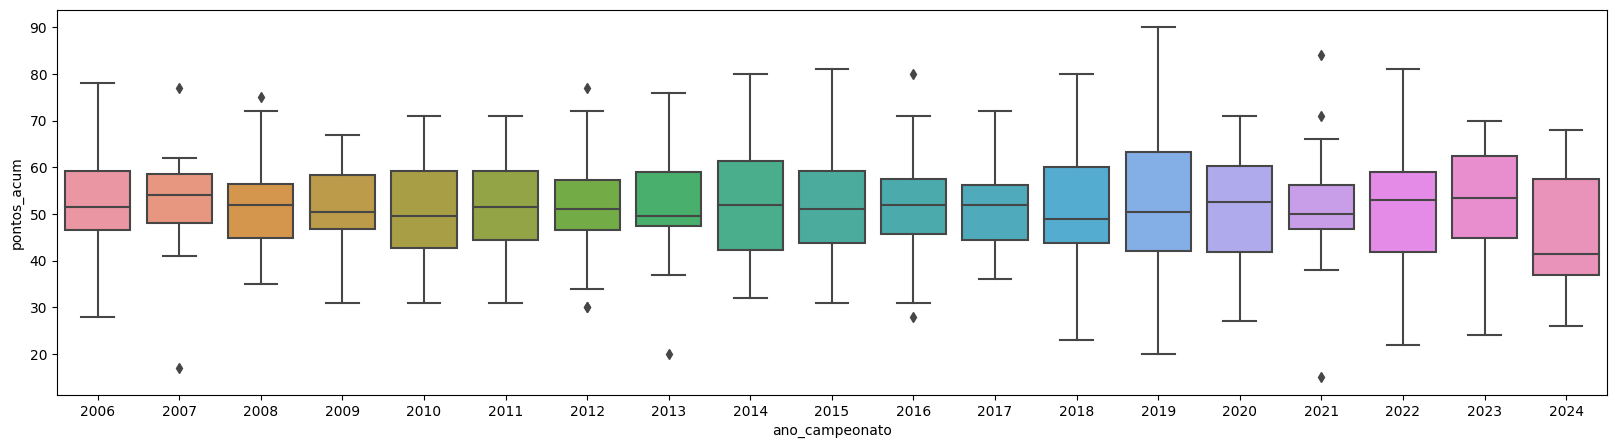

In [27]:
# Boxplot da distribuição dos pontos na última rodada entre os 20 times
plt.figure(figsize = (20,5))
sns.boxplot(data = df_rodada38, x = 'ano_campeonato', y = 'pontos_acum');

In [28]:
#Comparativo entre todos os times por temporada
filtro_ano1 = 2023
filtro_ano2 = 2024
select_top = 6
select_last = 4

plt.figure(figsize = (20,7))
df_plot = df_completo.loc[((df_completo.ano_campeonato == filtro_ano1) | (df_completo.ano_campeonato == filtro_ano2)) & ((df_completo.classificacao_final <= select_top) | (df_completo.classificacao_final > 20 - select_top)) ]
fig = px.line(df_plot, x ='rodada', y = 'pontos_acum', color = 'time', facet_col= 'ano_campeonato', title = f'Brasileirão {filtro_ano}', hover_data=['classificacao_final'])
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")

<Figure size 2000x700 with 0 Axes>

# Relação entre campeões do 1o Turno e Campeões Final

### Classificação Final dos Times "Campeões" do 1o Turno

In [29]:
#classificação turno1 para classificação final
df_plot = df_completo.groupby(['ano_campeonato','time'])[['classificacao_1o_turno','classificacao_final']].max().reset_index()
df_plot = df_plot.groupby(['classificacao_1o_turno','classificacao_final'])['time'].count().reset_index()
df_plot = df_plot.loc[df_plot.classificacao_1o_turno == 1]

display(df_plot)

#data
label = ['Turno1_1o',   #0

        'Final_1o.',    #1
        'Final_2o.',    #2
        'Final_3o.',    #3
        'Final_4o.',    #4
        'Final_5o.']    #5

source = [0,0,0,0]
target = [1,2,4,5]
value = df_plot.time.tolist()

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad = 35, thickness = 10)
data = go.Sankey(link = link, node = node, orientation = 'h')

fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title = 'Classificação Final dos Times "Campeões" do 1o Turno',
    font = dict(size = 10, color = 'white'),
    paper_bgcolor = '#51504f'
)
fig.show()

,classificacao_1o_turno,classificacao_final,time
0,1,1,13
1,1,2,3
2,1,4,1
3,1,5,2


### Classificação no 1o Turno dos Times Campeões

In [30]:
#classificação turno1 para campeões
df_plot = df_completo.groupby(['ano_campeonato','time'])[['classificacao_1o_turno','classificacao_final']].max().reset_index()
df_plot = df_plot.groupby(['classificacao_final','classificacao_1o_turno'])['time'].count().reset_index()
df_plot = df_plot.loc[df_plot.classificacao_final == 1]

display(df_plot)

#data
label = ['Campeões',   #0

        'Turno1_1o.',    #1
        'Turno1_2o.',    #2
        'Turno1_3o.',    #3
        'Turno1_4o.',    #4
        'Turno1_5o.',    #5
        'Turno1_6o.',    #6
        'Turno1_7o.',    #7
        'Turno1_8o.',    #8
        'Turno1_9o.',    #9
        'Turno1_10o.']   #10

target = [0,0,0,0,0,0]
source = [1,2,3,4,6,10]
value = df_plot.time.tolist()

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value)
node = dict(label = label, pad = 35, thickness = 10)
data = go.Sankey(link = link, node = node, orientation = 'h')

fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    title = 'Classificação no 1o Turno dos Times Campeões',
    font = dict(size = 10, color = 'white'),
    paper_bgcolor = '#51504f'
)
fig.show()

,classificacao_final,classificacao_1o_turno,time
0,1,1,13
1,1,2,1
2,1,3,2
3,1,4,1
4,1,6,1
5,1,10,1


# Similaridade de Cosseno

## Curva da posição 1 de cada ano_campeonato

In [31]:
df_pos1 = df_completo.groupby(['ano_campeonato','rodada'])['pontos_acum'].max().reset_index()
df_pos1 = df_pos1.pivot(index='rodada', columns='ano_campeonato', values='pontos_acum').reset_index()
df_pos1.index.name = None
display(df_pos1)

plt.figure(figsize = (20,7))
fig = px.line(df_pos1, x ='rodada', y = df_pos1.iloc[:,1:].columns, title = f'Brasileirão 2006 - 2024 | Pontos do 1o. colocado a cada rodada')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")
fig.show()

ano_campeonato,rodada,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,1,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0
1,2,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,4.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0
2,3,7.0,9.0,9.0,9.0,9.0,9.0,9.0,7.0,7.0,7.0,7.0,7.0,7.0,9.0,9.0,9.0,7.0,9.0,7.0
3,4,10.0,10.0,10.0,12.0,10.0,12.0,12.0,8.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,9.0,12.0,9.0
4,5,13.0,11.0,13.0,13.0,13.0,15.0,13.0,11.0,11.0,12.0,13.0,13.0,10.0,13.0,12.0,13.0,12.0,15.0,10.0
5,6,13.0,14.0,13.0,14.0,16.0,15.0,14.0,13.0,13.0,15.0,13.0,16.0,13.0,16.0,15.0,14.0,13.0,15.0,13.0
6,7,16.0,15.0,16.0,17.0,17.0,17.0,16.0,15.0,16.0,16.0,16.0,19.0,14.0,19.0,16.0,17.0,14.0,18.0,14.0
7,8,19.0,17.0,19.0,17.0,18.0,20.0,19.0,16.0,16.0,18.0,19.0,20.0,17.0,22.0,17.0,18.0,15.0,21.0,17.0
8,9,19.0,18.0,22.0,20.0,21.0,23.0,22.0,18.0,19.0,19.0,19.0,23.0,20.0,25.0,20.0,21.0,18.0,21.0,19.0
9,10,21.0,21.0,23.0,21.0,22.0,26.0,25.0,20.0,22.0,22.0,22.0,26.0,23.0,26.0,20.0,22.0,19.0,24.0,21.0


<Figure size 2000x700 with 0 Axes>

## Similaridade da Curva da pos #1 de 2024 (até a rodada atual) vs as curvas da pos #1 dos anos anteriores | Por Cosseno

ano_campeonato,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
ano_campeonato,,,,,,,,,,,,,,,,,,,
2006,1.000000,0.998299,0.997842,0.997763,0.996767,0.996503,0.999388,0.997943,0.997950,0.999404,0.999583,0.994883,0.999263,0.999174,0.998735,0.999392,0.998714,0.993236,0.999327
2007,0.998299,1.000000,0.996663,0.996447,0.994666,0.993115,0.997627,0.999478,0.997297,0.998955,0.998385,0.992447,0.998054,0.998850,0.999039,0.998800,0.999228,0.991262,0.998772
2008,0.997842,0.996663,1.000000,0.998319,0.998275,0.998012,0.998401,0.996873,0.999063,0.997650,0.996885,0.997945,0.998777,0.996682,0.998379,0.998357,0.996417,0.996853,0.997921
2009,0.997763,0.996447,0.998319,1.000000,0.999347,0.998572,0.998664,0.995740,0.998436,0.996923,0.997013,0.997973,0.997814,0.996278,0.998481,0.998060,0.995510,0.997708,0.997773
2010,0.996767,0.994666,0.998275,0.999347,1.000000,0.999065,0.997879,0.994313,0.998406,0.995860,0.995729,0.999041,0.997205,0.994726,0.997552,0.997275,0.993889,0.998434,0.996870
2011,0.996503,0.993115,0.998012,0.998572,0.999065,1.000000,0.997634,0.992724,0.997232,0.995161,0.995541,0.998306,0.996878,0.994476,0.996372,0.996431,0.992900,0.997561,0.995904
2012,0.999388,0.997627,0.998401,0.998664,0.997879,0.997634,1.000000,0.997112,0.998569,0.998593,0.998881,0.996313,0.999386,0.998229,0.998562,0.999022,0.997908,0.995256,0.999256
2013,0.997943,0.999478,0.996873,0.995740,0.994313,0.992724,0.997112,1.000000,0.997754,0.999019,0.997861,0.992619,0.998084,0.998426,0.998886,0.998867,0.999078,0.990978,0.998554
2014,0.997950,0.997297,0.999063,0.998436,0.998406,0.997232,0.998569,0.997754,1.000000,0.998209,0.997009,0.998086,0.998968,0.996490,0.998719,0.998933,0.997060,0.996917,0.998588


,ano_campeonato,2024
0,2018,0.999499
1,2021,0.999436
2,2006,0.999327
3,2015,0.999303
4,2012,0.999256
5,2016,0.999071
6,2020,0.998967
7,2022,0.998885
8,2019,0.998842
9,2007,0.998772


A maior similaridade com o ano 2024 é o ano: 2018
A similaridade entre o ano 2024 e o ano 2018 foi: 0.9994990342956493
Já que o ano com maior similaridade foi o ano 2018, qual time em 2024 possui maior similaridade com a curva da pos.1 de 2018?


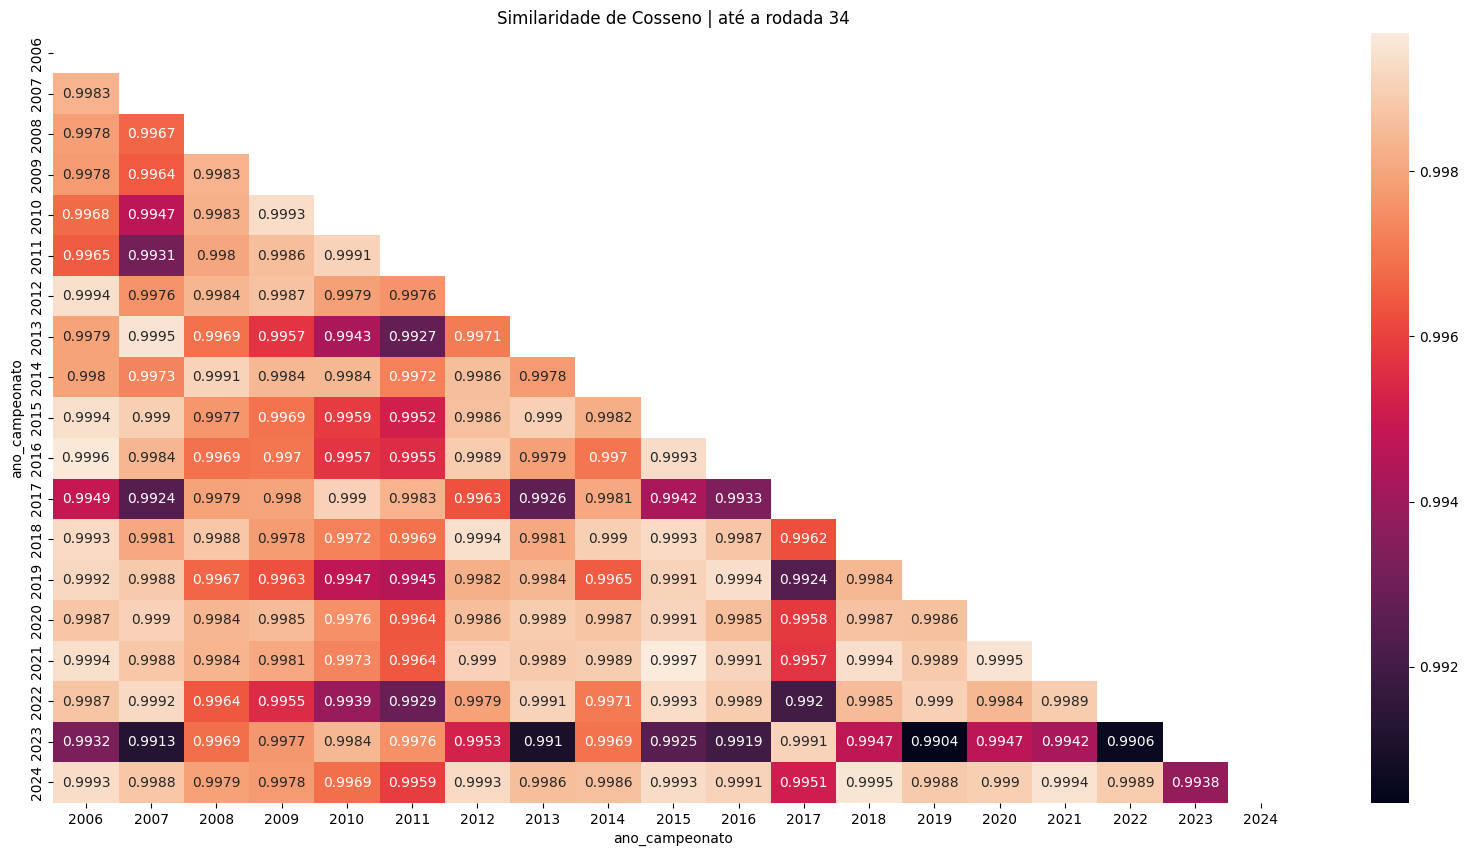

<Figure size 2000x700 with 0 Axes>

In [32]:
ano_analisado = 2024
ate_a_rodada = 34

df_cos_sim = df_pos1.loc[df_pos1.rodada <= ate_a_rodada].set_index('rodada', drop = True).T

# Calculando a similaridade do cosseno
cos_sim = cosine_similarity(df_cos_sim)
# display(cos_sim)

# Extraindo a similaridade da coluna 2009 com as outras colunas
similarity_2024 = cos_sim[-1, :-1]
# display(similarity_2024)

# Criando um dataframe para visualizar os resultados
similarity_df = pd.DataFrame(cos_sim, index = df_pos1.columns[1:],columns = df_pos1.columns[1:])

display(similarity_df)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(similarity_df)
# using the upper triangle matrix as mask 
plt.figure(figsize = (20,10))
plt.title(f'Similaridade de Cosseno | até a rodada {ate_a_rodada}')
sns.heatmap(similarity_df, annot=True, fmt='.4g', mask = matrix);

maior_similaridade_ano_analisado = similarity_df[ano_analisado].reset_index()
maior_similaridade_ano_analisado = maior_similaridade_ano_analisado.loc[maior_similaridade_ano_analisado.ano_campeonato != ano_analisado]
maior_similaridade_ano_analisado = maior_similaridade_ano_analisado.sort_values(ano_analisado, ascending = False).reset_index(drop = True)
display(maior_similaridade_ano_analisado)

# Obtendo o índice do valor máximo
max_cos_sim = maior_similaridade_ano_analisado[ano_analisado][0]
ano_max_cos_sim = maior_similaridade_ano_analisado['ano_campeonato'][0]

print(f'A maior similaridade com o ano {ano_analisado} é o ano: {ano_max_cos_sim}')
print(f'A similaridade entre o ano {ano_analisado} e o ano {ano_max_cos_sim} foi: {max_cos_sim}')

print(f'Já que o ano com maior similaridade foi o ano {ano_max_cos_sim}, qual time em 2024 possui maior similaridade com a curva da pos.1 de 2018?')

plt.figure(figsize = (20,7))
fig = px.line(df_pos1, x ='rodada', y = [int(ano_max_cos_sim), int(ano_analisado)], title = f'Brasileirão | Ano analisado: {ano_analisado} | Curva pos.1 com maior similaridade de cosseno: {ano_max_cos_sim}')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")



## Similaridade de cada time do ano 2024 com a curva pos.1 mais correlacionada nos anos anteriores (2018) | Por Cosseno

time,Atlético-GO,Atlético-MG,Atlético-PR,Botafogo,Corinthians,Criciúma EC,Cruzeiro,Cuiabá-MT,EC Bahia,EC Vitória,Flamengo,Fluminense,Fortaleza,Grêmio,Internacional,Juventude,Palmeiras,RB Bragantino,São Paulo,Vasco da Gama,2018
rodada,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,3.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,3.0,1.0,3.0,1.0,0.0,3.0,3.0
2,0.0,2.0,3.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,6.0,1.0,4.0,3.0,6.0,4.0,3.0,4.0,0.0,3.0,6.0
3,0.0,5.0,6.0,6.0,1.0,3.0,4.0,1.0,4.0,2.0,7.0,4.0,5.0,6.0,6.0,4.0,4.0,7.0,3.0,3.0,7.0
4,1.0,8.0,7.0,9.0,4.0,6.0,7.0,1.0,7.0,2.0,7.0,4.0,6.0,6.0,7.0,5.0,5.0,8.0,4.0,3.0,10.0
5,1.0,9.0,10.0,9.0,5.0,9.0,8.0,1.0,10.0,2.0,8.0,5.0,7.0,6.0,8.0,8.0,8.0,9.0,7.0,3.0,10.0
6,1.0,12.0,13.0,10.0,5.0,9.0,11.0,4.0,13.0,2.0,11.0,5.0,8.0,6.0,11.0,8.0,8.0,9.0,10.0,6.0,13.0
7,4.0,13.0,13.0,13.0,5.0,9.0,11.0,4.0,14.0,2.0,14.0,6.0,11.0,6.0,14.0,9.0,11.0,12.0,13.0,6.0,14.0
8,5.0,16.0,16.0,16.0,6.0,9.0,14.0,4.0,17.0,3.0,17.0,6.0,11.0,6.0,15.0,10.0,14.0,12.0,14.0,6.0,17.0
9,8.0,16.0,17.0,19.0,7.0,10.0,15.0,7.0,18.0,6.0,18.0,6.0,11.0,6.0,15.0,10.0,17.0,15.0,15.0,7.0,20.0


time,Atlético-GO,Atlético-MG,Atlético-PR,Botafogo,Corinthians,Criciúma EC,Cruzeiro,Cuiabá-MT,EC Bahia,EC Vitória,Flamengo,Fluminense,Fortaleza,Grêmio,Internacional,Juventude,Palmeiras,RB Bragantino,São Paulo,Vasco da Gama,2018
rodada,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,3.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,3.0,1.0,3.0,1.0,0.0,3.0,3.0
2,0.0,2.0,3.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,6.0,1.0,4.0,3.0,6.0,4.0,3.0,4.0,0.0,3.0,6.0
3,0.0,5.0,6.0,6.0,1.0,3.0,4.0,1.0,4.0,2.0,7.0,4.0,5.0,6.0,6.0,4.0,4.0,7.0,3.0,3.0,7.0
4,1.0,8.0,7.0,9.0,4.0,6.0,7.0,1.0,7.0,2.0,7.0,4.0,6.0,6.0,7.0,5.0,5.0,8.0,4.0,3.0,10.0
5,1.0,9.0,10.0,9.0,5.0,9.0,8.0,1.0,10.0,2.0,8.0,5.0,7.0,6.0,8.0,8.0,8.0,9.0,7.0,3.0,10.0
6,1.0,12.0,13.0,10.0,5.0,9.0,11.0,4.0,13.0,2.0,11.0,5.0,8.0,6.0,11.0,8.0,8.0,9.0,10.0,6.0,13.0
7,4.0,13.0,13.0,13.0,5.0,9.0,11.0,4.0,14.0,2.0,14.0,6.0,11.0,6.0,14.0,9.0,11.0,12.0,13.0,6.0,14.0
8,5.0,16.0,16.0,16.0,6.0,9.0,14.0,4.0,17.0,3.0,17.0,6.0,11.0,6.0,15.0,10.0,14.0,12.0,14.0,6.0,17.0
9,8.0,16.0,17.0,19.0,7.0,10.0,15.0,7.0,18.0,6.0,18.0,6.0,11.0,6.0,15.0,10.0,17.0,15.0,15.0,7.0,20.0


'Em 2024, até a rodada 34, os times com maiores similaridades com a curva pos.1 do ano 2018 são os times:'

,time,2018
0,2018,1.000000
1,Flamengo,0.999079
2,Botafogo,0.998550


,time,2018
0,2018,1.000000
1,Flamengo,0.999079
2,Botafogo,0.998550
3,Palmeiras,0.997896
4,Juventude,0.997861
5,Criciúma EC,0.997721
6,São Paulo,0.997683
7,Atlético-MG,0.997396
8,Cruzeiro,0.997340
9,EC Bahia,0.996560


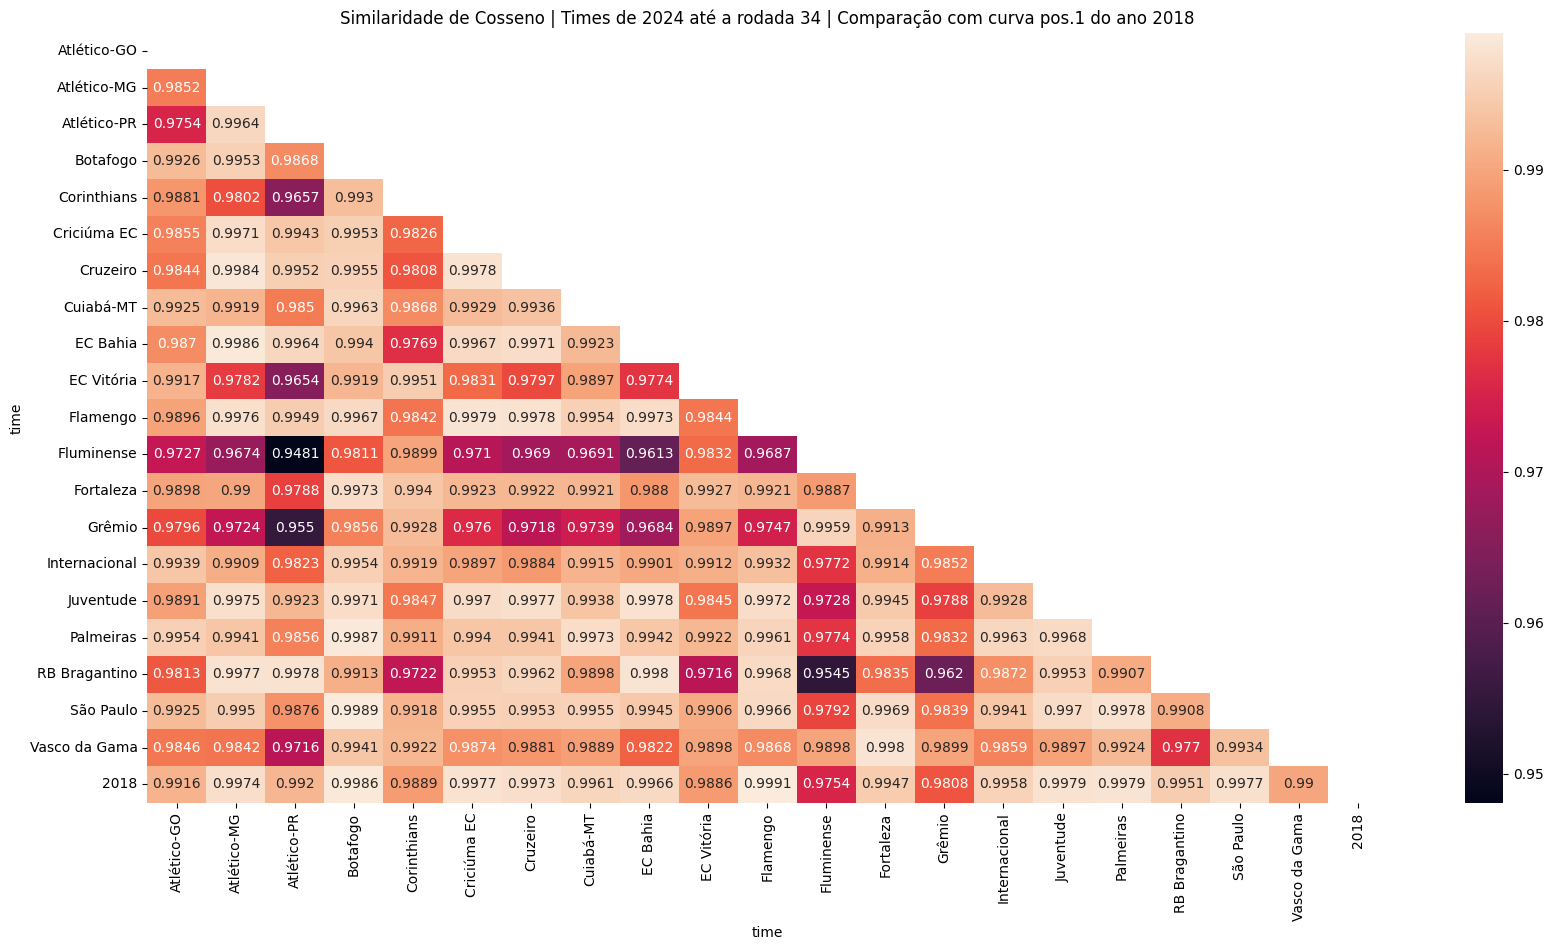

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

In [33]:
# Análise dos times do ano selecionado em comparação ao ano com maior similaridade
df_times_ano_analisado = df_completo.loc[(df_completo.ano_campeonato == ano_analisado) & (df_completo.rodada <= ate_a_rodada)][['time', 'rodada','pontos_acum']]

df_times_ano_analisado = df_times_ano_analisado.pivot(index = 'rodada', columns = 'time', values = 'pontos_acum').reset_index()

#adicionando a coluna do ano com maior similaridade
df_times_ano_analisado[ano_max_cos_sim] = df_pos1[ano_max_cos_sim]

#filtrando o dataframe até a rodada selecionada
df_times_ano_analisado = df_times_ano_analisado.loc[df_times_ano_analisado.rodada <= ate_a_rodada]
df_times_ano_analisado.set_index('rodada', inplace = True)
df_times_ano_analisado.dropna(inplace = True)
display(df_times_ano_analisado)


df_times_ano_analisado.dropna(inplace = True)
display(df_times_ano_analisado)

###########################################################################################################################################

#analisando similaridade de cosseno de cada time do ano escolhido com a curva pos.1 do ano com maior similaridade com o ano escolhido

# Calculando a similaridade do cosseno
cos_sim_times = cosine_similarity(df_times_ano_analisado.T)
# display(df_times_ano_analisado.T)
# display(cos_sim_times)

# Criando um dataframe para visualizar os resultados
similarity_df_times = pd.DataFrame(cos_sim_times, index = df_times_ano_analisado.columns,columns = df_times_ano_analisado.columns)

# display(similarity_df_times)

#########################################################################################################################################
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(similarity_df_times)
# using the upper triangle matrix as mask 
plt.figure(figsize = (20,10))
plt.title(f'Similaridade de Cosseno | Times de {ano_analisado} até a rodada {ate_a_rodada} | Comparação com curva pos.1 do ano {ano_max_cos_sim}')
sns.heatmap(similarity_df_times, annot=True, fmt='.4g', mask = matrix);

maior_similaridade_time = similarity_df_times[ano_max_cos_sim].reset_index()
maior_similaridade_time = maior_similaridade_time.loc[maior_similaridade_time[ano_max_cos_sim] < 1]

maior_similaridade_time = maior_similaridade_time.sort_values(ano_max_cos_sim, ascending = False).reset_index(drop = True)

display(f'Em {ano_analisado}, até a rodada {ate_a_rodada}, os times com maiores similaridades com a curva pos.1 do ano {ano_max_cos_sim} são os times:', maior_similaridade_time.head(3))

#######################################
#Plot
plt.figure(figsize = (20,7))
fig = px.line(df_times_ano_analisado)#, x =df_times_ano_analisado.index+1, y = df_times_ano_analisado.columns, title = f'Brasileirão 2006 - 2024 | Pontos do 1o. colocado a cada rodada')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")
fig.show()
display(maior_similaridade_time)
#######################################
#Plot top 3 mais similares com a curva pos#1 do ano referencia
list_top_3_similaridade = maior_similaridade_time['time'][:4].tolist()
# list_top_3_similaridade.insert(0,ano_max_cos_sim)

plt.figure(figsize = (20,7))
fig = px.line(df_times_ano_analisado[list_top_3_similaridade], 
              title = f'Curva pos#1 de {ano_analisado} possui maior similaridade de cosseno com a curva de {ano_max_cos_sim} <br><sup>Top 3 times de {ano_analisado} com maior similaridade de cosseno com a curva pos#1 de {ano_max_cos_sim}</sup>')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")
fig.show()


# Similaridade por menor RMSE

## Similaridade da Curva da pos #1 de 2024 (até a rodada atual) vs as curvas da pos #1 dos anos anteriores | Por RMSE

In [34]:
df_pos1_ate_rodada_atual = df_pos1.loc[df_pos1.rodada <= ate_a_rodada].set_index('rodada', drop = True)
list_cols = df_pos1_ate_rodada_atual.columns.tolist()
list_rmse = []
for col in list_cols:
    rmse_col = rmse(df_pos1_ate_rodada_atual[ano_analisado], df_pos1_ate_rodada_atual[col])
    list_rmse.append(rmse_col)

df_rmse_sim = pd.DataFrame({'ano_campeonato':list_cols, f'rmse_{ano_analisado}':list_rmse})
df_rmse_sim = df_rmse_sim.sort_values(df_rmse_sim.columns[-1]).reset_index(drop = True)
display(df_rmse_sim)

#ano com maior similaridade por RMSE com o ano analisado
ano_min_rmse_sim = df_rmse_sim.ano_campeonato.iloc[1]
#######################################

plt.figure(figsize = (20,7))
fig = px.line(df_pos1, x ='rodada', y = [int(ano_max_cos_sim), int(ano_analisado)], title = f'Brasileirão | Ano analisado: {ano_analisado} | Curva pos.1 com maior similaridade RMSE: {ano_min_rmse_sim}')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")


,ano_campeonato,rmse_2024
0,2024,0.000000
1,2018,1.306094
2,2006,1.740521
3,2016,1.886484
4,2020,2.294495
5,2022,2.332633
6,2014,2.455486
7,2007,2.461468
8,2015,2.634611
9,2013,2.760009


<Figure size 2000x700 with 0 Axes>

## Similaridade de cada time do ano 2024 com a curva pos.1 mais correlacionada nos anos anteriores (2018) | Por RMSE

In [35]:
# Análise dos times do ano selecionado em comparação ao ano com maior similaridade
df_times_ano_analisado = df_completo.loc[(df_completo.ano_campeonato == ano_analisado) & (df_completo.rodada <= ate_a_rodada)][['time', 'rodada','pontos_acum']]

df_times_ano_analisado = df_times_ano_analisado.pivot(index = 'rodada', columns = 'time', values = 'pontos_acum').reset_index()

#adicionando a coluna do ano com maior similaridade
df_times_ano_analisado[ano_min_rmse_sim] = df_pos1[ano_min_rmse_sim]

#filtrando o dataframe até a rodada selecionada
df_times_ano_analisado = df_times_ano_analisado.loc[df_times_ano_analisado.rodada <= ate_a_rodada]
df_times_ano_analisado.set_index('rodada', inplace = True)
df_times_ano_analisado.dropna(inplace = True)
display(df_times_ano_analisado)

###########################################################################################################################################

#calculando o RMSE de cada time do ano escolhido com a curva pos.1 do ano com maior similaridade com o ano escolhido

# Calculando o RMSE
list_cols = df_times_ano_analisado.columns.tolist()
list_rmse = []
for time in list_cols:
    rmse_col = rmse(df_times_ano_analisado[time], df_times_ano_analisado[ano_min_rmse_sim])
    list_rmse.append(rmse_col)

df_times_rmse_sim = pd.DataFrame({'time':list_cols, f'rmse_{int(ano_analisado)}_{int(ano_min_rmse_sim)}':list_rmse})
df_times_rmse_sim = df_times_rmse_sim.sort_values(df_times_rmse_sim.columns[-1]).reset_index(drop = True)
display(df_times_rmse_sim.iloc[1:4,:])

plt.figure(figsize = (20,7))
fig = px.line(df_times_ano_analisado, 
              title = f'Curva pos#1 de {ano_analisado} possui maior similaridade por RMSE com a curva de {ano_max_cos_sim} <br><sup>Top 3 times de {ano_analisado} com maior similaridade de cosseno com a curva pos#1 de {ano_max_cos_sim}</sup>')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")
fig.show()
#######################################
#Plot top 4 mais similares com a curva pos#1 do ano referencia
list_top_3_similaridade = df_times_rmse_sim['time'][:5].tolist()

plt.figure(figsize = (20,7))
fig = px.line(df_times_ano_analisado[list_top_3_similaridade], 
              title = f'Curva pos#1 de {ano_analisado} possui maior similaridade por RMSE com a curva de {ano_max_cos_sim} <br><sup>Top 3 times de {ano_analisado} com maior similaridade de cosseno com a curva pos#1 de {ano_max_cos_sim}</sup>')
fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")
fig.update_xaxes(ticktext=np.arange(1,33))
fig.show()

time,Atlético-GO,Atlético-MG,Atlético-PR,Botafogo,Corinthians,Criciúma EC,Cruzeiro,Cuiabá-MT,EC Bahia,EC Vitória,Flamengo,Fluminense,Fortaleza,Grêmio,Internacional,Juventude,Palmeiras,RB Bragantino,São Paulo,Vasco da Gama,2018
rodada,,,,,,,,,,,,,,,,,,,,,
1,0.0,1.0,3.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,3.0,1.0,3.0,0.0,3.0,1.0,3.0,1.0,0.0,3.0,3.0
2,0.0,2.0,3.0,3.0,1.0,2.0,4.0,1.0,3.0,1.0,6.0,1.0,4.0,3.0,6.0,4.0,3.0,4.0,0.0,3.0,6.0
3,0.0,5.0,6.0,6.0,1.0,3.0,4.0,1.0,4.0,2.0,7.0,4.0,5.0,6.0,6.0,4.0,4.0,7.0,3.0,3.0,7.0
4,1.0,8.0,7.0,9.0,4.0,6.0,7.0,1.0,7.0,2.0,7.0,4.0,6.0,6.0,7.0,5.0,5.0,8.0,4.0,3.0,10.0
5,1.0,9.0,10.0,9.0,5.0,9.0,8.0,1.0,10.0,2.0,8.0,5.0,7.0,6.0,8.0,8.0,8.0,9.0,7.0,3.0,10.0
6,1.0,12.0,13.0,10.0,5.0,9.0,11.0,4.0,13.0,2.0,11.0,5.0,8.0,6.0,11.0,8.0,8.0,9.0,10.0,6.0,13.0
7,4.0,13.0,13.0,13.0,5.0,9.0,11.0,4.0,14.0,2.0,14.0,6.0,11.0,6.0,14.0,9.0,11.0,12.0,13.0,6.0,14.0
8,5.0,16.0,16.0,16.0,6.0,9.0,14.0,4.0,17.0,3.0,17.0,6.0,11.0,6.0,15.0,10.0,14.0,12.0,14.0,6.0,17.0
9,8.0,16.0,17.0,19.0,7.0,10.0,15.0,7.0,18.0,6.0,18.0,6.0,11.0,6.0,15.0,10.0,17.0,15.0,15.0,7.0,20.0


,time,rmse_2024_2018
1,Botafogo,2.181187
2,Palmeiras,3.684529
3,Flamengo,4.362374


<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

# Similaridade por menor RMSE | Turno 2: Peso 3

## Similaridade da Curva da pos #1 de 2024 (até a rodada atual) vs as curvas da pos #1 dos anos anteriores | Por RMSE | Turno 1: Peso 1, Turno 2: Peso 3

In [36]:
def identificar_curva_pos1_menor_rmse(ano_analisado: int, ate_a_rodada: int):
    '''
    Função para identificar o ano cuja curva da posição #1 de cada rodada apresenta maior similaridade com a curva do ano + rodada escolhidos

    ARGS
    ano_analisado: ano em estudo para realizar a projeção
    ate_a_rodada: ou a última rodada realizada ou rodada anteriores para avaliar o algoritmo
    '''

    df_pos1_ate_rodada_atual = df_pos1.loc[df_pos1.rodada <= ate_a_rodada]
    df_pos1_ate_rodada_atual.index.name = None
    df_pos1_ate_rodada_atual.columns.name = None
    list_cols = df_pos1_ate_rodada_atual.columns.tolist()
    # display(df_pos1_ate_rodada_atual)

    if ate_a_rodada <= 19:
        list_rmse = []
        for col in list_cols:
            rmse_col = rmse(df_pos1_ate_rodada_atual[ano_analisado], df_pos1_ate_rodada_atual[col])
            list_rmse.append(rmse_col)

    else: #rodada > 19
        df_turno1 = df_pos1_ate_rodada_atual.loc[df_pos1_ate_rodada_atual.rodada <= 19]
        df_turno2 = df_pos1_ate_rodada_atual.loc[df_pos1_ate_rodada_atual.rodada > 19]

        list_rmse = []
        for col in list_cols:
            rmse_col_t1 = rmse(df_turno1[ano_analisado], df_turno1[col])
            rmse_col_t2 = rmse(df_turno2[ano_analisado], df_turno2[col])
            rmse_col = (rmse_col_t1 + (3*rmse_col_t2))/4
            list_rmse.append(rmse_col)

    df_rmse_sim = pd.DataFrame({'ano_campeonato':list_cols, f'rmse_{ano_analisado}':list_rmse})
    df_rmse_sim = df_rmse_sim.sort_values(df_rmse_sim.columns[-1]).reset_index(drop = True)
    # display(df_rmse_sim)

    #ano com maior similaridade por RMSE com o ano analisado
    ano_min_rmse_sim = df_rmse_sim.ano_campeonato.iloc[1]
    min_rmse = df_rmse_sim.iloc[1,1]
    print(f'{"#"*50}\nANO: {ano_analisado} | RODADA: {rodada_loop} | Maior Similaridade com pos#1 de {ano_min_rmse_sim}\n{"#"*50}')
    #######################################

    plt.figure(figsize = (20,7))
    fig = px.line(df_pos1_ate_rodada_atual, x ='rodada', y = [int(ano_min_rmse_sim), int(ano_analisado)], title = f'Brasileirão | Ano analisado: {ano_analisado} | Até a rodada: {ate_a_rodada} | Turno 2: Peso 3 | Curva pos.1 com maior similaridade por RMSE: Ano {ano_min_rmse_sim} | RMSE {min_rmse}')
    fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")
    fig.show();

    return ano_min_rmse_sim, min_rmse


## Similaridade de cada time do ano 2024 com a curva pos.1 mais correlacionada nos anos anteriores (2018) | Por RMSE | Turno 2: Peso 3

In [37]:
def identificar_g4_menor_rmse(ano_analisado: int, ate_a_rodada: int, ano_min_rmse_sim: int):
    '''
    Função para identificar os times g4 com menor RMSE em relação a curva pos.1 do ano mais similar ao ano escolhido

    ARGS
    ano_analisado: ano em estudo para realizar a projeção
    ate_a_rodada: ou a última rodada realizada ou rodada anteriores para avaliar o algoritmo
    ano_min_rmse_sim: ano cuja curva pos.1 apresenta maior similaridade com o ano escolhido (esta variável é a saída da função "identificar_curva_pos1_menor_rmse")
    '''

    # Análise dos times do ano selecionado em comparação ao ano com maior similaridade
    df_times_ano_analisado = df_completo.loc[(df_completo.ano_campeonato == ano_analisado) & (df_completo.rodada <= ate_a_rodada)][['time', 'rodada','pontos_acum']]
    df_times_ano_analisado = df_times_ano_analisado.pivot(index = 'rodada', columns = 'time', values = 'pontos_acum').reset_index()

    #adicionando a coluna do ano com maior similaridade
    df_pos1_ate_rodada_atual = df_pos1.loc[df_pos1.rodada <= ate_a_rodada]
    df_pos1_ate_rodada_atual.index.name = None
    df_pos1_ate_rodada_atual.columns.name = None
    # list_cols = df_pos1_ate_rodada_atual.columns.tolist()

    #filtrando o dataframe até a rodada selecionada
    df_times_ano_analisado[ano_min_rmse_sim] = df_pos1_ate_rodada_atual[ano_min_rmse_sim]
    df_times_ano_analisado.dropna(inplace = True)

    ###########################################################################################################################################

    #calculando o RMSE de cada time do ano escolhido com a curva pos.1 do ano com maior similaridade com o ano escolhido

    # Calculando o RMSE
    list_times = df_times_ano_analisado.columns.tolist()
    list_rmse = []

    if ate_a_rodada <= 19:
        for time in list_times:
            rmse_col = rmse(df_times_ano_analisado[time], df_times_ano_analisado[ano_min_rmse_sim])
            list_rmse.append(rmse_col)

    else:
        df_times_ano_analisado = df_times_ano_analisado.reset_index()
        df_turno1 = df_times_ano_analisado.loc[df_times_ano_analisado.rodada <= 19]
        df_turno2 = df_times_ano_analisado.loc[(df_times_ano_analisado.rodada > 19) & (df_times_ano_analisado.rodada <= ate_a_rodada)]
        for time in list_times:
            rmse_col_t1 = rmse(df_turno1[time], df_turno1[ano_min_rmse_sim])
            rmse_col_t2 = rmse(df_turno2[time], df_turno2[ano_min_rmse_sim])
            rmse_col = (rmse_col_t1 + (3*rmse_col_t2))/4
            list_rmse.append(rmse_col)
            # print(time, rmse_col_t1, rmse_col_t2, rmse_col)

    df_times_rmse_sim = pd.DataFrame({'time':list_times, f'rmse_{int(ano_analisado)}_{int(ano_min_rmse_sim)}':list_rmse})
    df_times_rmse_sim = df_times_rmse_sim.sort_values(df_times_rmse_sim.columns[-1]).reset_index(drop = True)

    # # #######################################
    #Plot top 4 mais similares com a curva pos#1 do ano referencia
    list_top_4_similaridade = df_times_rmse_sim['time'][:5].tolist()
    display(df_times_rmse_sim.iloc[1:5, :])

    plt.figure(figsize = (20,7))
    fig = px.line(df_times_ano_analisado[list_top_4_similaridade], 
                # title = f'Top 4 times de {ano_analisado} com maior similaridade por RMSE com a curva pos.1 de {ano_min_rmse_sim}</sup>')
                title =f'Brasileirão | Ano analisado: {ano_analisado} | Até a rodada: {ate_a_rodada} | Turno 2: Peso 3 | Top 4 times de {ano_analisado} com maior similaridade por RMSE com a curva pos.1 de {ano_min_rmse_sim}')
    fig.add_vline(x=19, line_width=3, line_dash="dash", line_color="green")
    fig.update_xaxes(ticktext=np.arange(1,33))
    fig.show()
    return



# Validação do algoritmo
* A melhor forma de avaliação de fato foi por RMSE, atribuindo Peso maior ao turno 2.
* A seguir simularemos a projeção dos top 4 a partir da rodada 20, recalculando qual é o ano cuja curva pos.1 apresenta menor RMSE com a curva do ano em análise

In [38]:
for rodada_loop in (np.arange(28, ate_a_rodada)):
    ano_min_rmse_sim, min_rmse = identificar_curva_pos1_menor_rmse(ano_analisado = ano_analisado, ate_a_rodada = rodada_loop)
    identificar_g4_menor_rmse(ano_analisado = ano_analisado, ate_a_rodada = rodada_loop, ano_min_rmse_sim= ano_min_rmse_sim)

##################################################
ANO: 2024 | RODADA: 28 | Maior Similaridade com pos#1 de 2020
##################################################


,time,rmse_2024_2020
1,Botafogo,1.486403
2,Fortaleza,3.557871
3,Palmeiras,4.188182
4,Flamengo,4.704750


##################################################
ANO: 2024 | RODADA: 29 | Maior Similaridade com pos#1 de 2018
##################################################


,time,rmse_2024_2018
1,Botafogo,2.043403
2,Fortaleza,4.172562
3,Flamengo,4.332322
4,Palmeiras,4.346398


##################################################
ANO: 2024 | RODADA: 30 | Maior Similaridade com pos#1 de 2018
##################################################


,time,rmse_2024_2018
1,Botafogo,1.995894
2,Palmeiras,4.209560
3,Fortaleza,4.406115
4,Flamengo,4.795861


##################################################
ANO: 2024 | RODADA: 31 | Maior Similaridade com pos#1 de 2018
##################################################


,time,rmse_2024_2018
1,Botafogo,1.955012
2,Palmeiras,4.091231
3,Fortaleza,4.586739
4,Flamengo,4.962018


##################################################
ANO: 2024 | RODADA: 32 | Maior Similaridade com pos#1 de 2018
##################################################


,time,rmse_2024_2018
1,Botafogo,1.919416
2,Palmeiras,4.125743
3,Fortaleza,4.731401
4,Flamengo,5.097932


##################################################
ANO: 2024 | RODADA: 33 | Maior Similaridade com pos#1 de 2018
##################################################


,time,rmse_2024_2018
1,Botafogo,1.888109
2,Palmeiras,4.058860
3,Fortaleza,4.723449
4,Flamengo,5.211314


<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

In [39]:
df_campeoes = df_classificacao38_ano.loc[(df_classificacao38_ano.classificacao_final == 1)][['ano_campeonato','time']].reset_index(drop = True)
df_campeoes

,ano_campeonato,time
0,2006,São Paulo
1,2007,São Paulo
2,2008,São Paulo
3,2009,Flamengo
4,2010,Fluminense
5,2011,Corinthians
6,2012,Fluminense
7,2013,Cruzeiro
8,2014,Cruzeiro
9,2015,Corinthians


In [40]:
ano_analisado = 2024
ate_a_rodada = 32

for ano_loop in (np.arange(2018, 2025)):
    time_campeao_ano_loop = df_campeoes.loc[df_campeoes.ano_campeonato == ano_loop]['time'].values[0]
    print(f'{"#"*50}\nCampeão de {ano_loop}: {time_campeao_ano_loop}\n{"#"*50}')
    ano_min_rmse_sim, min_rmse = identificar_curva_pos1_menor_rmse(ano_analisado = ano_loop, ate_a_rodada = ate_a_rodada)
    identificar_g4_menor_rmse(ano_analisado = ano_loop, ate_a_rodada = ate_a_rodada, ano_min_rmse_sim = ano_min_rmse_sim)

##################################################
Campeão de 2018: Palmeiras
##################################################
##################################################
ANO: 2018 | RODADA: 33 | Maior Similaridade com pos#1 de 2024
##################################################


,time,rmse_2018_2024
1,Internacional,3.446715
2,Palmeiras,3.623809
3,Flamengo,3.894603
4,São Paulo,4.443738


##################################################
Campeão de 2019: Flamengo
##################################################
##################################################
ANO: 2019 | RODADA: 33 | Maior Similaridade com pos#1 de 2021
##################################################


,time,rmse_2019_2021
1,Palmeiras,3.932267
2,Flamengo,3.960559
3,Santos,6.486135
4,São Paulo,11.810472


##################################################
Campeão de 2020: Flamengo
##################################################
##################################################
ANO: 2020 | RODADA: 33 | Maior Similaridade com pos#1 de 2006
##################################################


,time,rmse_2020_2006
1,São Paulo,3.115765
2,Atlético-MG,4.089068
3,Flamengo,4.091841
4,Internacional,5.154410


##################################################
Campeão de 2021: Atlético-MG
##################################################
##################################################
ANO: 2021 | RODADA: 33 | Maior Similaridade com pos#1 de 2015
##################################################


,time,rmse_2021_2015
1,Atlético-MG,2.282204
2,Flamengo,6.754795
3,Palmeiras,7.709591
4,Fortaleza,11.460428


##################################################
Campeão de 2022: Palmeiras
##################################################
##################################################
ANO: 2022 | RODADA: 33 | Maior Similaridade com pos#1 de 2015
##################################################


,time,rmse_2022_2015
1,Palmeiras,1.915215
2,Internacional,9.134819
3,Corinthians,9.278417
4,Fluminense,10.073051


##################################################
Campeão de 2023: Palmeiras
##################################################
##################################################
ANO: 2023 | RODADA: 33 | Maior Similaridade com pos#1 de 2017
##################################################


,time,rmse_2023_2017
1,Botafogo,1.373688
2,Palmeiras,9.038877
3,Flamengo,10.141165
4,RB Bragantino,10.384587


##################################################
Campeão de 2024: Botafogo
##################################################
##################################################
ANO: 2024 | RODADA: 33 | Maior Similaridade com pos#1 de 2018
##################################################


,time,rmse_2024_2018
1,Botafogo,1.919416
2,Palmeiras,4.125743
3,Fortaleza,4.731401
4,Flamengo,5.097932


<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>